In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch import optim

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Generate Dataset

In [3]:
k = 10 #Stiffness
m = 5 # mass
F_0 = 3 #force
b = 0.6 # Damping Co-efficient
w_0 = np.sqrt(k/m) # Natural Frequency
w = np.random.uniform(w_0/4, 5*w_0/2, 1000) #Frequencies
def Amplitude(w):
  A = F_0/np.sqrt(m*np.square(np.square(w)-np.square(w_0)) + np.square(b)*np.square(w))
  return A

A = Amplitude(w)

In [6]:
import pandas as pd

data= {
    'Frequencies':w,
    'Amplitude' :A
          }
df = pd.DataFrame(data)
print(df)


     Frequencies  Amplitude
0       0.459519   0.748230
1       2.165331   0.487742
2       1.961178   0.698861
3       0.394030   0.726087
4       3.126728   0.171531
..           ...        ...
995     2.707268   0.249441
996     0.940078   1.172354
997     0.428008   0.736989
998     0.724555   0.901775
999     3.396841   0.140017

[1000 rows x 2 columns]


In [7]:
train=df.sample(frac=0.5,random_state=200) #random state is a seed value
test=df.drop(train.index)
print(test)


     Frequencies  Amplitude
0       0.459519   0.748230
2       1.961178   0.698861
3       0.394030   0.726087
6       1.414315   3.535280
7       3.524726   0.128184
..           ...        ...
991     0.489303   0.759934
992     1.698810   1.346561
994     1.771652   1.087234
996     0.940078   1.172354
997     0.428008   0.736989

[500 rows x 2 columns]


In [8]:
train_inp = torch.tensor(train['Frequencies'].values, dtype=torch.float32) # design space includes frequency for the start
train_out = torch.tensor(train['Amplitude'].values, dtype=torch.float32) # just displacement/velocity as scalar output (take the amplitude)
test_inp = torch.tensor(test['Frequencies'].values, dtype=torch.float32)
test_out = torch.tensor(test['Amplitude'].values, dtype=torch.float32)

# ML Model for Amplitude Prediction

In [4]:
class Amplitude_Predictor(nn.Module):
    def __init__(self, input_size, num_outputs, hidden_layers):
        super(Amplitude_Predictor, self).__init__()

        layers = []
        for i in range(len(hidden_layers)):
            if i == 0:
                layers.append(nn.Linear(input_size, hidden_layers[i]))
            else:
                layers.append(nn.Linear(hidden_layers[i-1], hidden_layers[i]))
            layers.append(nn.ReLU())

        # Add the output layer
        layers.append(nn.Linear(hidden_layers[-1], num_outputs))

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        x = self.net(x)
        return x

# Training

In [5]:
input_size = 1
num_outputs = 1
hidden_layers = [500, 500] # Add hidden layers in a list [n1, n2, ...], where n1, n2 represents number of neurons in each layer
learning_rate = 0.001
batch_size = int(50)
num_epochs = 1000

In [9]:
model = Amplitude_Predictor(input_size=input_size, num_outputs=num_outputs, hidden_layers=hidden_layers)

In [10]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
model.train()

Amplitude_Predictor(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=1, bias=True)
  )
)

In [12]:
for epoch in range(num_epochs):
  train_loss = 0.0
  for i in range((train_inp.shape[0]-1)//batch_size+1):
    start_i = i*batch_size
    end_i = start_i+batch_size
    x = train_inp[start_i:end_i]
    y = train_out[start_i:end_i]
    scores = model(torch.unsqueeze(x,1))
    loss = criterion(scores, torch.unsqueeze(y,1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss += loss.item()

  valid_loss = 0.0
  model.eval()
  data, targets = test_inp, test_out
  scores = model(torch.unsqueeze(data,1))
  with torch.no_grad():
    loss = criterion(scores, torch.unsqueeze(targets,1))
  valid_loss += loss.item()

  print(f'Epoch {epoch+1} \t\t Training Loss: { train_loss / len(train_inp)} \t\t Validation Loss: {valid_loss / len(test_inp)}')

Epoch 1 		 Training Loss: 0.02118406355381012 		 Validation Loss: 0.0017053771018981933
Epoch 2 		 Training Loss: 0.011408216774463653 		 Validation Loss: 0.001076883316040039
Epoch 3 		 Training Loss: 0.008394570469856262 		 Validation Loss: 0.000596178412437439
Epoch 4 		 Training Loss: 0.00529499301314354 		 Validation Loss: 0.000532473623752594
Epoch 5 		 Training Loss: 0.004213337138295173 		 Validation Loss: 0.00044042927026748655
Epoch 6 		 Training Loss: 0.0038101656287908552 		 Validation Loss: 0.00040092572569847104
Epoch 7 		 Training Loss: 0.0035424798280000685 		 Validation Loss: 0.0003727584779262543
Epoch 8 		 Training Loss: 0.0032928789258003235 		 Validation Loss: 0.00033801794052124023
Epoch 9 		 Training Loss: 0.0029865960627794264 		 Validation Loss: 0.0003018954694271088
Epoch 10 		 Training Loss: 0.002676501601934433 		 Validation Loss: 0.0002623770534992218
Epoch 11 		 Training Loss: 0.002333365246653557 		 Validation Loss: 0.00022961193323135375
Epoch 12 		 Trai

In [13]:
np.max(train_loss / len(train_inp))

1.3610607084046932e-07

# Plot Amplitude Predictions

In [14]:
w.sort()
fre = torch.tensor(w, dtype=torch.float32)
sorted_input, indices =torch.sort(fre)
predicted = model(torch.unsqueeze(sorted_input,1))

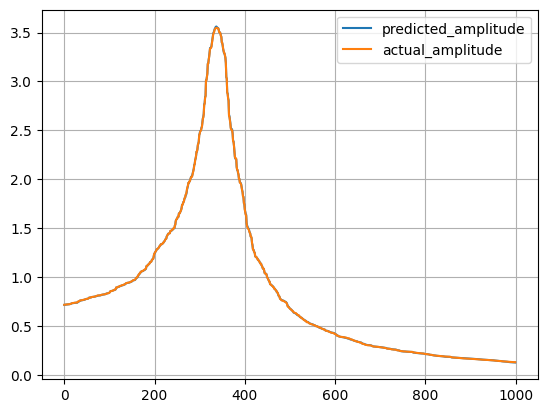

In [15]:
plt.plot(predicted.detach().numpy())

plt.plot(Amplitude(w))
plt.legend(['predicted_amplitude', 'actual_amplitude'], loc='upper right')
plt.grid()
plt.show()

# Evaluation

In [16]:
model.eval()

Amplitude_Predictor(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=1, bias=True)
  )
)

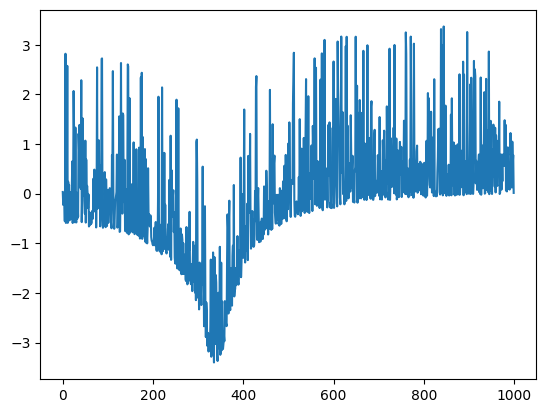

Error of the curve is 0.0033665447759530158


In [17]:
e = A.reshape(1000,1) - predicted.detach().numpy()
plt.plot(e)
plt.show()
error = np.max(e/len(e))
print('Error of the curve is', error )